UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/20
613/613 [==============================] - 117s 188ms/step - loss: 4.8328 - accuracy: 0.4836 - val_loss: 1.0836 - val_accuracy: 0.6776
Epoch 2/20
613/613 [==============================] - 123s 201ms/step - loss: 3.0245 - accuracy: 0.6265 - val_loss: 0.9302 - val_accuracy: 0.7208
Epoch 3/20
613/613 [==============================] - 89s 145ms/step - loss: 2.6921 - accuracy: 0.6627 - val_loss: 0.8896 - val_accuracy: 0.7357
Epoch 4/20
613/613 [==============================] - 116s 189ms/step - loss: 2.5195 - accuracy: 0.6829 - val_loss: 0.8677 - val_accuracy: 0.7435
Epoch 5/20
613/613 [==============================] - 112s 183ms/step - loss: 2.4000 - accuracy: 0.6897 - val_loss: 0.8511 - val_accuracy: 0.7511
Epoch 6/20
613/613 [==============================] - 123s 201ms/step - loss: 2.3576 - accuracy: 0.6981 - val_loss: 0.8489 - val_accuracy: 0.7460
Epoch 7/20
613/613 [==============================] - 91s 149ms/step -

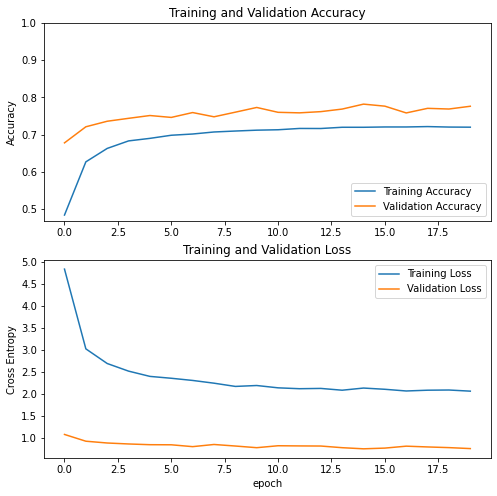

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)
        
epochs = 20
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('GTSD_trainX.npy', allow_pickle=True)
test_X = np.load('GTSD_testX.npy', allow_pickle=True)
train_Y = np.load('GTSD_trainY.npy', allow_pickle=True)
test_Y = np.load('GTSD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

# import pre-trained model
base_model = tf.keras.models.load_model('output/chinesetrafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(43, activation='softmax',name = 'output'))

for layer in model.layers[:-1]:
    layer.trainable = False # freeze the layer

initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

final_layer1_weights_values = model.layers[0].get_weights()
#check if layer[0] has changed during the training, the other layers may be checked in a similar way
np.testing.assert_allclose(         
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.save('CtoG_Transfer_Learning_1', [acc,loss,val_acc,val_loss])

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/20
613/613 [==============================] - 277s 438ms/step - loss: 3.0386 - accuracy: 0.6519 - val_loss: 0.5230 - val_accuracy: 0.8395
Epoch 2/20
613/613 [==============================] - 235s 383ms/step - loss: 1.2574 - accuracy: 0.8247 - val_loss: 0.3517 - val_accuracy: 0.8958
Epoch 3/20
613/613 [==============================] - 197s 322ms/step - loss: 0.9141 - accuracy: 0.8686 - val_loss: 0.3189 - val_accuracy: 0.9059
Epoch 4/20
613/613 [==============================] - 130s 212ms/step - loss: 0.7064 - accuracy: 0.8959 - val_loss: 0.2997 - val_accuracy: 0.9112
Epoch 5/20
613/613 [==============================] - 154s 251ms/step - loss: 0.5975 - accuracy: 0.9105 - val_loss: 0.3208 - val_accuracy: 0.9105
Epoch 6/20
613/613 [==============================] - 142s 232ms/step - loss: 0.5404 - accuracy: 0.9178 - val_loss: 0.2663 - val_accuracy: 0.9277
Epoch 7/20
613/613 [==============================] - 132s 216ms/step

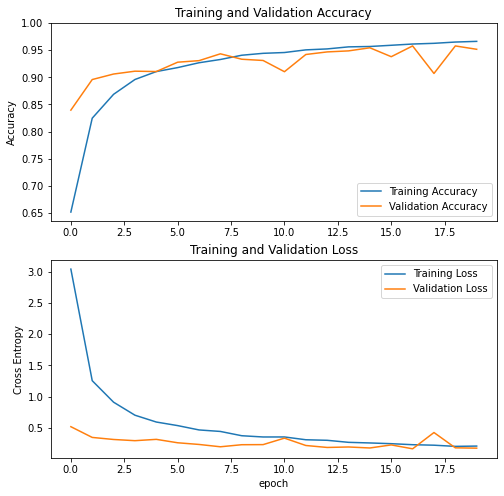

In [5]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)
        
epochs = 20
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('GTSD_trainX.npy', allow_pickle=True)
test_X = np.load('GTSD_testX.npy', allow_pickle=True)
train_Y = np.load('GTSD_trainY.npy', allow_pickle=True)
test_Y = np.load('GTSD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

# import pre-trained model
base_model = tf.keras.models.load_model('output/chinesetrafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(43, activation='softmax',name = 'output'))

#for layer in model.layers[:-1]:
    #layer.trainable = False # freeze the layer

initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

#final_layer1_weights_values = model.layers[0].get_weights()
#check if layer[0] has changed during the training, the other layers may be checked in a similar way
#np.testing.assert_allclose(         
    #initial_layer1_weights_values[0], final_layer1_weights_values[0]
#)
#np.testing.assert_allclose(
    #initial_layer1_weights_values[1], final_layer1_weights_values[1]
#)


acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.save('CtoG_Transfer_Learning_15', [acc,loss,val_acc,val_loss])

In [9]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#data_path = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD"
#def load_data(dataset):
    #images = []
    #classes = []
    #rows = pd.read_csv(dataset)
    #rows = rows.sample(frac=1).reset_index(drop=True)
    #for i, row in rows.iterrows():
        #img_class = row["ClassId"]
        #img_path = row["Path"]
        #image = os.path.join(data_path, img_path)
        #image = cv2.imread(image)
        #image_rs = cv2.resize(image, (32, 32), 3)
        #R, G, B = cv2.split(image_rs)
        #img_r = cv2.equalizeHist(R)
        #img_g = cv2.equalizeHist(G)
        #img_b = cv2.equalizeHist(B)
        #new_image = cv2.merge((img_r, img_g, img_b))
        #if i % 500 == 0:
            #print(f"loaded: {i}")
        #images.append(new_image)
        #classes.append(img_class)
    #X = np.array(images)
    #y = np.array(classes)
    
    #return (X, y)
        
epochs = 20
learning_rate = 0.001
batch_size = 64

#####Run this part for the first time and save the pre-processed data. So you do not have to process it every time
#train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Train Complete.csv"
#test_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/TSRD/TSRD Test Complete.csv"
#(train_X, train_Y) = load_data(train_data)
#(test_X, test_Y) = load_data(test_data)
#np.save('TSRD_trainX',train_X)
#np.save('TSRD_trainY',train_Y)
#np.save('TSRD_testX',test_X)
#np.save('TSRD_testY',test_Y)

train_X = np.load('GTSD_trainX.npy', allow_pickle=True)
test_X = np.load('GTSD_testX.npy', allow_pickle=True)
train_Y = np.load('GTSD_trainY.npy', allow_pickle=True)
test_Y = np.load('GTSD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX = test_X.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY = to_categorical(test_Y, num_labels)

class_totals = trainY.sum(axis=0)
class_weights = class_totals.max() / class_totals
class_weight_dict = dict(enumerate(class_weights))

data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

# import pre-trained model
base_model = tf.keras.models.load_model('output/chinesetrafficsignnet.model')
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))

model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
model.add(Dense(43, activation='softmax',name = 'output'))

for layer in model.layers[:-5]:
    layer.trainable = False # freeze the layer

#initial_layer1_weights_values = model.layers[0].get_weights()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX, testY),
    class_weight=class_weight_dict,
    verbose=1)

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
Epoch 1/20
613/613 [==============================] - 69s 111ms/step - loss: 3.6820 - accuracy: 0.5909 - val_loss: 0.8036 - val_accuracy: 0.7600
Epoch 2/20
613/613 [==============================] - 77s 126ms/step - loss: 2.0775 - accuracy: 0.7260 - val_loss: 0.6958 - val_accuracy: 0.7979
Epoch 3/20
613/613 [==============================] - 72s 117ms/step - loss: 1.7548 - accuracy: 0.7608 - val_loss: 0.6602 - val_accuracy: 0.8087
Epoch 4/20
613/613 [==============================] - 71s 116ms/step - loss: 1.6118 - accuracy: 0.7762 - val_loss: 0.6724 - val_accuracy: 0.8068
Epoch 5/20
613/613 [==============================] - 79s 129ms/step - loss: 1.4769 - accuracy: 0.7922 - val_loss: 0.6340 - val_accuracy: 0.8173
Epoch 6/20
613/613 [==============================] - 70s 114ms/step - loss: 1.3807 - accuracy: 0.8031 - val_loss: 0.6139 - val_accuracy: 0.8192
Epoch 7/20
613/613 [==============================] - 72s 118ms/step - loss